In [15]:
import os
import random
import shutil
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split


# GPU memory growth configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
def split_data1(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

  
  shuffled_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))

  
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING

  for item in shuffled_source:
    item_source = os.path.join(SOURCE, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else: 
      shutil.copyfile(item_source, os.path.join(target, item))
      i += 1

    
    if i == training_number:
      target = TESTING

In [17]:
source_path = r"/Users/sulthanfatahillah/Downloads/Datasets"

source_ai_dir = r"/Users/sulthanfatahillah/Downloads/Datasets/AI"
source_human_dir = r"/Users/sulthanfatahillah/Downloads/Datasets/Non-AI"

training_dir = r"/Users/sulthanfatahillah/Downloads/split-data/Training"
validation_dir = r"/Users/sulthanfatahillah/Downloads/split-data/Validation"

train_ai_dir = os.path.join(training_dir, 'AI')
train_human_dir = os.path.join(training_dir, 'Non-Ai')

val_human_dir = os.path.join(validation_dir, 'Non-AI')
val_ai_dir = os.path.join(validation_dir, 'AI')

if len(os.listdir(train_human_dir)) > 0:
  for file in os.scandir(train_human_dir):
    os.remove(file.path)
if len(os.listdir(train_ai_dir)) > 0:
  for file in os.scandir(train_ai_dir):
    os.remove(file.path)
if len(os.listdir(val_human_dir)) > 0:
  for file in os.scandir(val_human_dir):
    os.remove(file.path)
if len(os.listdir(val_ai_dir)) > 0:
  for file in os.scandir(val_ai_dir):
    os.remove(file.path)
    
split_size = .9


!find /Users/sulthanfatahillah/Downloads/Datasets -type f ! -name "*.jpg" -exec rm {} +

split_data1(source_human_dir, train_human_dir, val_human_dir, split_size)
split_data1(source_ai_dir, train_ai_dir, val_ai_dir, split_size)

print(f"There are {len(os.listdir(train_human_dir))} images of human art for training")
print(f"There are {len(os.listdir(train_ai_dir))} images of AI generated for training")
print(f"There are {len(os.listdir(val_human_dir))} images of human art for validation")
print(f"There are {len(os.listdir(val_ai_dir))} images of AI generated for validation")

There are 21713 images of human art for training
There are 20250 images of AI generated for training
There are 2413 images of human art for validation
There are 2251 images of AI generated for validation


In [29]:

def create_model():

  model = tf.keras.models.Sequential([
      
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

  return model



In [30]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('accuracy') > 0.95):

     
      print("\nAccuracy lebih dari 95, stop training!")
      self.model.stop_training = True


callbacks = myCallback()

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        training_dir,  
        target_size=(150, 150),  
        batch_size=32,
        class_mode='binary')


validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 41963 images belonging to 2 classes.
Found 4664 images belonging to 2 classes.


In [32]:
EPOCHS = 30


model = create_model()


history = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      verbose=2,
      callbacks=[callbacks])

Epoch 1/30
1312/1312 - 336s - loss: 0.5266 - accuracy: 0.7872 - val_loss: 0.4736 - val_accuracy: 0.7890 - 336s/epoch - 256ms/step
Epoch 2/30
1312/1312 - 325s - loss: 0.3452 - accuracy: 0.8349 - val_loss: 0.6326 - val_accuracy: 0.6546 - 325s/epoch - 247ms/step
Epoch 3/30
1312/1312 - 321s - loss: 0.2926 - accuracy: 0.8685 - val_loss: 0.3702 - val_accuracy: 0.8360 - 321s/epoch - 245ms/step
Epoch 4/30
1312/1312 - 328s - loss: 0.2608 - accuracy: 0.8865 - val_loss: 0.4382 - val_accuracy: 0.8182 - 328s/epoch - 250ms/step
Epoch 5/30
1312/1312 - 329s - loss: 0.2268 - accuracy: 0.9031 - val_loss: 0.3818 - val_accuracy: 0.8278 - 329s/epoch - 250ms/step
Epoch 6/30
1312/1312 - 338s - loss: 0.2063 - accuracy: 0.9129 - val_loss: 0.3499 - val_accuracy: 0.8536 - 338s/epoch - 258ms/step
Epoch 7/30
1312/1312 - 320s - loss: 0.1926 - accuracy: 0.9190 - val_loss: 0.4785 - val_accuracy: 0.8308 - 320s/epoch - 244ms/step
Epoch 8/30
1312/1312 - 321s - loss: 0.1772 - accuracy: 0.9254 - val_loss: 0.3464 - val_acc

In [33]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'ro', label='Training Loss')
  plt.plot(epochs, val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

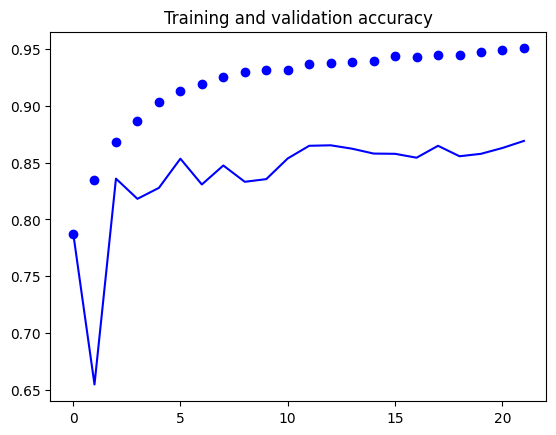

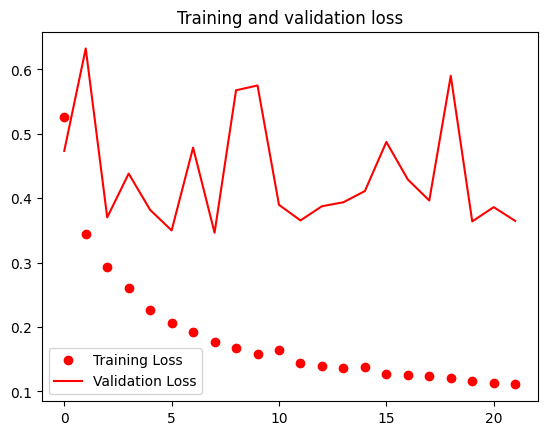

In [34]:
plot_loss_acc(history)

In [35]:
model.save('latestmodel.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [79]:
import numpy as np
import os
from keras.models import load_model
from keras.preprocessing import image


model = load_model('latestmodel.h5')


image_directory = '/Users/sulthanfatahillah/Downloads/split-data/Validation/AI'


uploaded_files = os.listdir(image_directory)

for fn in uploaded_files:
    
    path = os.path.join(image_directory, fn)

    
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

   
    images = np.vstack([x])
    classes = model.predict(images, batch_size=32)
    print(classes[0])

  
    if classes[0] > 0.5:
        print(fn + " is a human art")
    else:
        print(fn + " is an AI generated")


1/1 [==============================] - 0s 78ms/step
[0.]
AI-Images--- (11312).jpg is an AI generated
1/1 [==============================] - 0s 23ms/step
[0.]
AI-Images--- (8002).jpg is an AI generated
1/1 [==============================] - 0s 22ms/step
[0.]
823.jpg is an AI generated
1/1 [==============================] - 0s 21ms/step
[0.]
10335.jpg is an AI generated
1/1 [==============================] - 0s 20ms/step
[0.]
6414.jpg is an AI generated
1/1 [==============================] - 0s 22ms/step
[0.]
5135.jpg is an AI generated
1/1 [==============================] - 0s 22ms/step
[0.]
11765.jpg is an AI generated
1/1 [==============================] - 0s 21ms/step
[0.]
5647.jpg is an AI generated
1/1 [==============================] - 0s 21ms/step
[0.]
13166.jpg is an AI generated
1/1 [==============================] - 0s 28ms/step
[0.]
AI-Images--- (5325).jpg is an AI generated
1/1 [==============================] - 0s 20ms/step
[0.]
AI-Images--- (7932).jpg is an AI generated
1/

In [80]:
import joblib

joblib.dump(model,'latestmodel.joblib')

['latestmodel.joblib']

In [81]:
import pickle

with open('latestmodel.pkl', 'wb') as f:
    pickle.dump(model,f)

In [82]:
from keras.models import load_model


model = load_model('latestmodel.h5')  


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('latestmodel.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/k5/btcb7n5557sf9xy2f7wdrcnr0000gn/T/tmp0fhspe1h/assets


INFO:tensorflow:Assets written to: /var/folders/k5/btcb7n5557sf9xy2f7wdrcnr0000gn/T/tmp0fhspe1h/assets
2023-12-21 21:55:19.595957: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-21 21:55:19.596146: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-21 21:55:19.602524: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/k5/btcb7n5557sf9xy2f7wdrcnr0000gn/T/tmp0fhspe1h
2023-12-21 21:55:19.603674: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-21 21:55:19.603679: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/k5/btcb7n5557sf9xy2f7wdrcnr0000gn/T/tmp0fhspe1h
2023-12-21 21:55:19.608468: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-12-21 21:55:19.610160: I tensorflow/cc/saved_model/load